# Finetune ResNet50


With 1920x1080 silence-removed melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50_1080silence'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
from data_preprocessing.AveragePoolResize import AveragePoolResize

learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    AveragePoolResize((224, 224)),  # Resize to 224x224 via average pooling
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_28308\3223105130.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:56<00:00,  1.32it/s, Loss=1.3405479192733765, Elapsed=67.7391s, ETA=0.0000s]  


Epoch 1 completed in 333.2095s
Train Loss: 1.371562977746732 - Train Accuracy: 43.090386920241514
Validation Loss: 1.2380803648630778 - Validation Accuracy: 47.02406078514141

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:56<00:00,  1.33it/s, Loss=1.0497955083847046, Elapsed=67.1536s, ETA=0.0000s]  


Epoch 2 completed in 333.2129s
Train Loss: 1.2066054683544731 - Train Accuracy: 48.99029872684923
Validation Loss: 1.200321865081787 - Validation Accuracy: 49.609539890249046

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:55<00:00,  1.36it/s, Loss=0.893798828125, Elapsed=65.8748s, ETA=0.0000s]      


Epoch 3 completed in 329.5320s
Train Loss: 1.1592421831423148 - Train Accuracy: 50.61170032337577
Validation Loss: 1.2039773551623028 - Validation Accuracy: 48.40650063317856

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.8508986234664917, Elapsed=65.5789s, ETA=0.0000s]  


Epoch 4 completed in 325.6415s
Train Loss: 1.134048175777314 - Train Accuracy: 51.606702697813255
Validation Loss: 1.1398595070838928 - Validation Accuracy: 50.47488391726467

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.7745175957679749, Elapsed=65.6625s, ETA=0.0000s]  


Epoch 5 completed in 325.4921s
Train Loss: 1.1185490990305222 - Train Accuracy: 51.902942041111686
Validation Loss: 1.1533932145436605 - Validation Accuracy: 49.957788096243135

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.9138660430908203, Elapsed=65.6830s, ETA=0.0000s]  


Epoch 6 completed in 326.5159s
Train Loss: 1.1047445382341483 - Train Accuracy: 52.617534655480426
Validation Loss: 1.1444471208254496 - Validation Accuracy: 51.40354579991558

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.788587212562561, Elapsed=65.5531s, ETA=0.0000s]   


Epoch 7 completed in 325.0166s
Train Loss: 1.091415443689148 - Train Accuracy: 53.17835417561791
Validation Loss: 1.1593562936782837 - Validation Accuracy: 51.846770789362594

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.5873099565505981, Elapsed=65.6843s, ETA=0.0000s]  


Epoch 8 completed in 326.5588s
Train Loss: 1.0819119788663236 - Train Accuracy: 53.232627032405425
Validation Loss: 1.1296066562334697 - Validation Accuracy: 50.20050654284508

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.7791894674301147, Elapsed=65.5343s, ETA=0.0000s]  


Epoch 9 completed in 325.1915s
Train Loss: 1.0707796560546565 - Train Accuracy: 53.648718934442904
Validation Loss: 1.108380188147227 - Validation Accuracy: 50.369354157872515

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.5897601246833801, Elapsed=65.5686s, ETA=0.0000s]  


Epoch 10 completed in 325.7452s
Train Loss: 1.0651778532245946 - Train Accuracy: 54.18466339521947
Validation Loss: 1.1196418793996175 - Validation Accuracy: 49.65175179400591

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.6710687875747681, Elapsed=65.3120s, ETA=0.0000s]  


Epoch 11 completed in 324.1024s
Train Loss: 1.0582638474213595 - Train Accuracy: 54.31130006105697
Validation Loss: 1.2322271537780762 - Validation Accuracy: 46.98184888138455

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=1.1194543838500977, Elapsed=65.6832s, ETA=0.0000s]  


Epoch 12 completed in 325.0846s
Train Loss: 1.046425336358175 - Train Accuracy: 55.046244996721015
Validation Loss: 1.093831574122111 - Validation Accuracy: 55.87800759814267

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.9518662095069885, Elapsed=66.0008s, ETA=0.0000s]  


Epoch 13 completed in 324.7289s
Train Loss: 1.038548662827883 - Train Accuracy: 55.21810904321476
Validation Loss: 1.118617467880249 - Validation Accuracy: 52.057830308146904

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.6201860308647156, Elapsed=65.7703s, ETA=0.0000s]  


Epoch 14 completed in 325.1829s
Train Loss: 1.0381831159825958 - Train Accuracy: 55.02815404445851
Validation Loss: 1.0763116319974264 - Validation Accuracy: 53.42971718024483

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.8443794250488281, Elapsed=65.6269s, ETA=0.0000s]  


Epoch 15 completed in 329.6411s
Train Loss: 1.022225115340569 - Train Accuracy: 55.49173469618507
Validation Loss: 1.0937332304318745 - Validation Accuracy: 53.925707049387924

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:55<00:00,  1.36it/s, Loss=0.7349696159362793, Elapsed=65.9086s, ETA=0.0000s]  


Epoch 16 completed in 324.6370s
Train Loss: 1.0260284996101623 - Train Accuracy: 55.46007552972569
Validation Loss: 1.0820636161168415 - Validation Accuracy: 55.593077247783874

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.36it/s, Loss=0.8128538131713867, Elapsed=65.7491s, ETA=0.0000s]  


Epoch 17 completed in 325.2299s
Train Loss: 1.014557187612346 - Train Accuracy: 55.78571267045069
Validation Loss: 1.0699928069114686 - Validation Accuracy: 55.63528915154073

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=0.8053072094917297, Elapsed=65.4494s, ETA=0.0000s]  


Epoch 18 completed in 325.2111s
Train Loss: 1.0106657734840592 - Train Accuracy: 56.317134393161616
Validation Loss: 1.0693695402145387 - Validation Accuracy: 55.529759392148584

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:55<00:00,  1.36it/s, Loss=0.8786289095878601, Elapsed=66.0623s, ETA=0.0000s]  


Epoch 19 completed in 326.1294s
Train Loss: 1.000752142915836 - Train Accuracy: 56.45281653513037
Validation Loss: 1.0914121540387471 - Validation Accuracy: 55.30814689742507

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=1.020120620727539, Elapsed=65.8206s, ETA=0.0000s]   

Epoch 20 completed in 324.4648s
Train Loss: 1.0002206095381279 - Train Accuracy: 56.56588498677099
Validation Loss: 1.088850687344869 - Validation Accuracy: 54.579991557619245



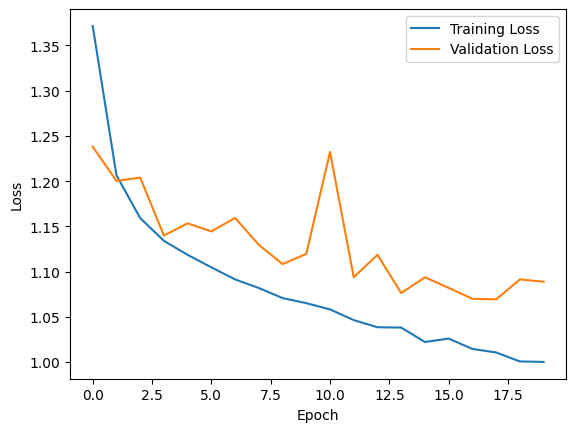

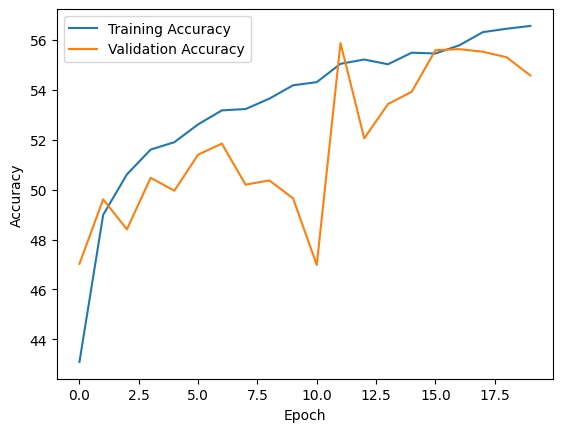

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_28308\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [01:13<00:00,  1.01it/s]

Test Accuracy: 0.5503
Test Precision: 0.5829
Test Recall: 0.5503
Test F1-score: 0.5474

              precision    recall  f1-score   support

       Anger       0.48      0.60      0.53       916
       Bored       0.70      0.77      0.73      1098
     Disgust       0.28      0.70      0.40       291
        Fear       0.32      0.58      0.41       308
       Happy       0.68      0.31      0.43      1914
     Neutral       0.55      0.50      0.52      2226
    Question       0.67      0.71      0.69      1139
         Sad       0.55      0.55      0.55       857
    Surprise       0.52      0.62      0.56       728

    accuracy                           0.55      9477
   macro avg       0.53      0.59      0.54      9477
weighted avg       0.58      0.55      0.55      9477



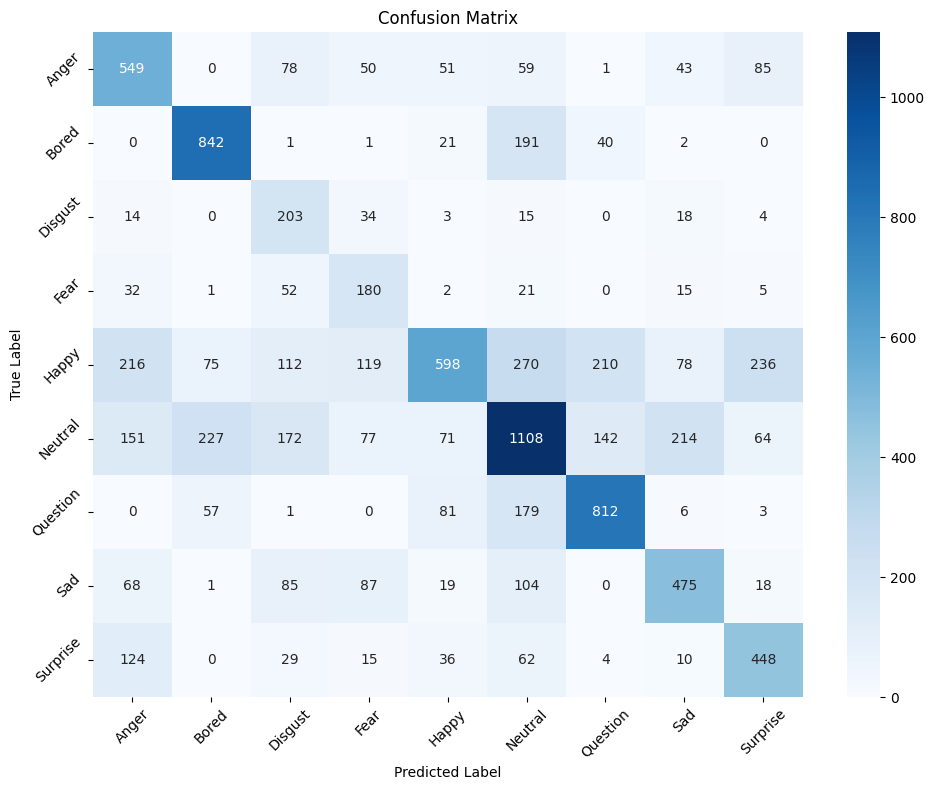

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)